## Multiple plots

- This notebook plots the raw lightcurve and mad applied lightcurve to see if the cleaning process has worked well.
- After, we revisit the MAD plots to see if the edge of lightcurve effects (flux high/low) were removed.
- We plot cadence vs bit to observe the flags given by `eleanor` for this lightcurve

In [1]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


In [2]:
from analysis_tools_cython import *
from post_processing_tools import *
from astropy.stats import sigma_clip,sigma_clipped_stats
from astropy.table import Table
import pandas as pd
import glob
from astropy.table import unique

In [4]:
data = get_output('output_s6_corr.txt')

In [5]:
mad_df = pd.read_json("./data/Sectors_MAD.json")
sec = 6
clip = 4

In [6]:
data.file

0          tesslc_234556256.pkl
1          tesslc_167974071.pkl
2          tesslc_255700743.pkl
3          tesslc_445939140.pkl
4          tesslc_176615627.pkl
                   ...         
2779720    tesslc_220211279.pkl
2779721    tesslc_206895034.pkl
2779722    tesslc_172778639.pkl
2779723     tesslc_79690705.pkl
2779724    tesslc_220479588.pkl
Name: file, Length: 2779725, dtype: object

In [7]:
path = '/storage/astro2/phrdhx/tesslcs'

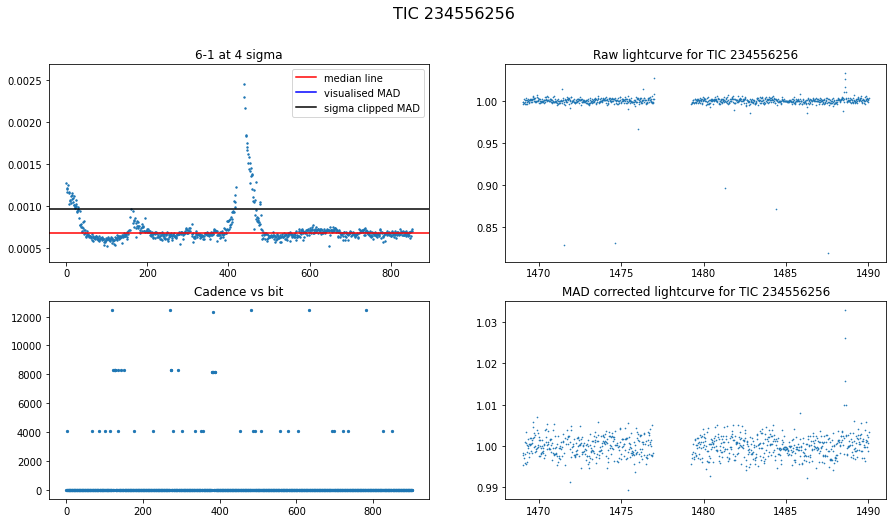

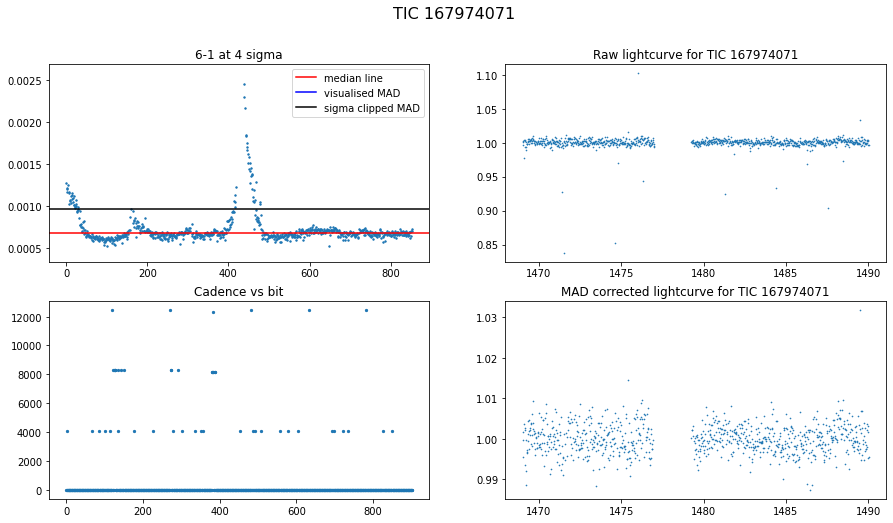

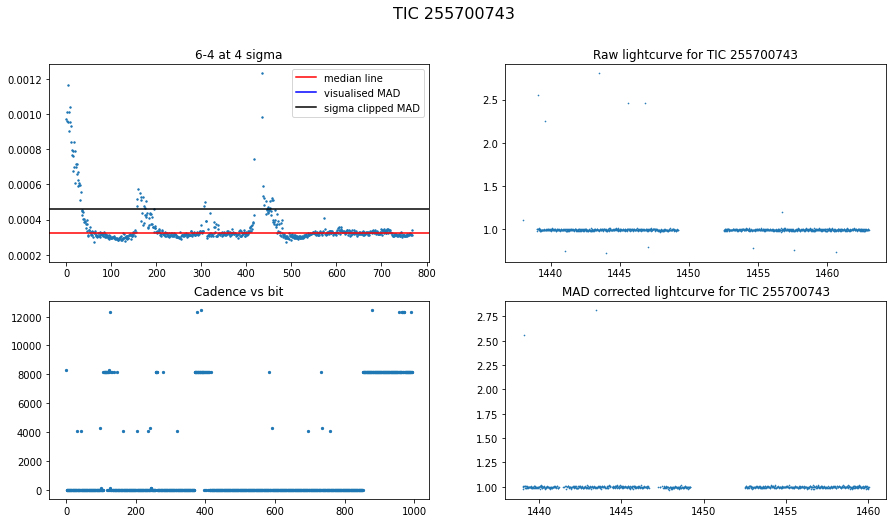

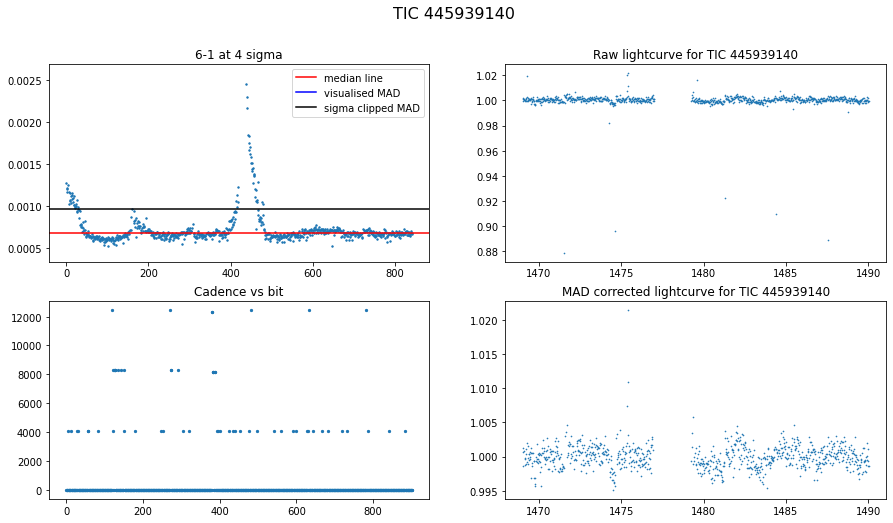

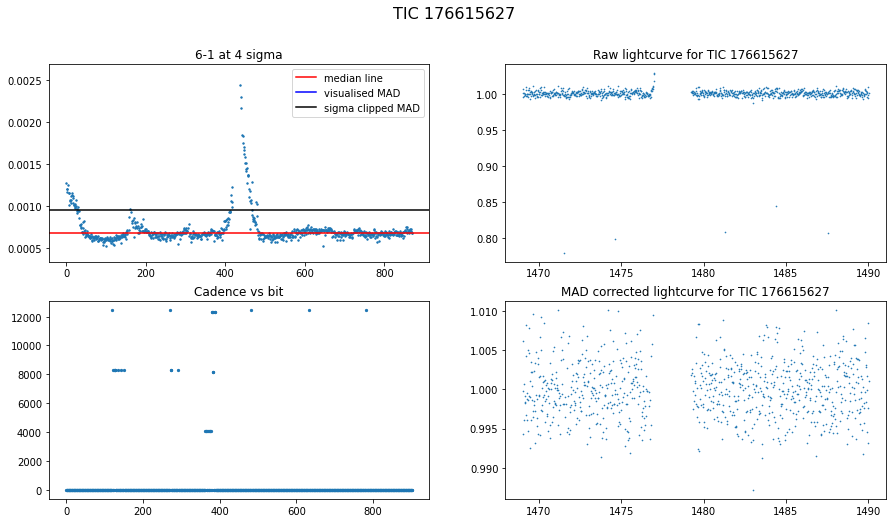

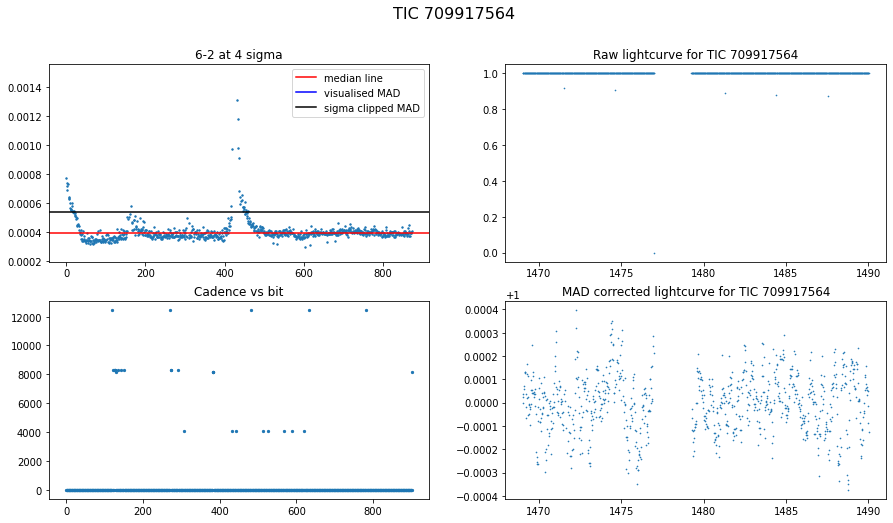

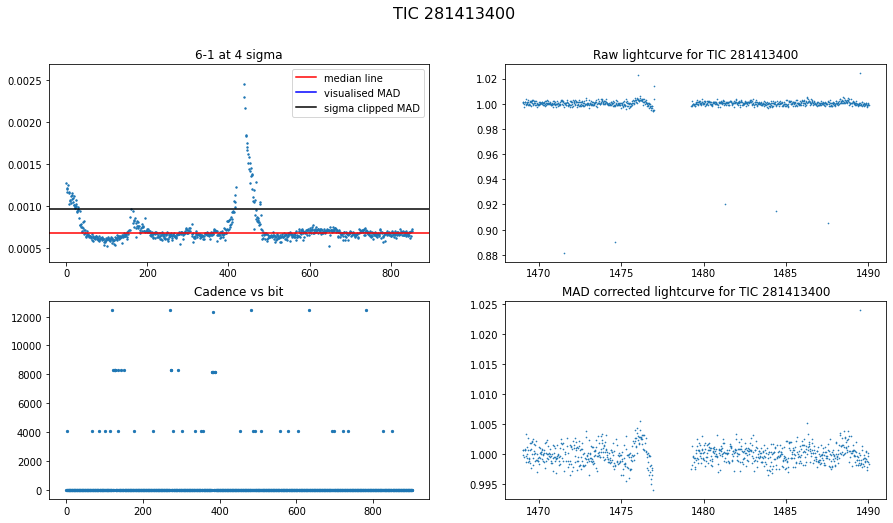

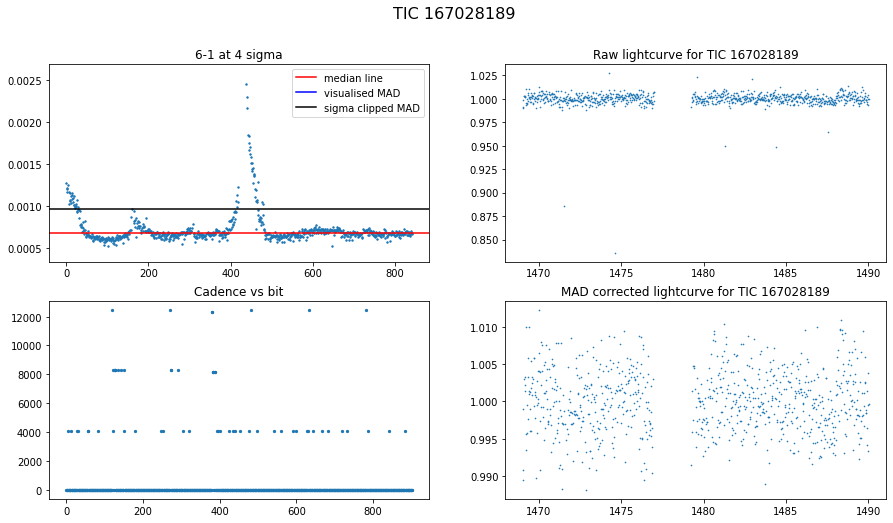

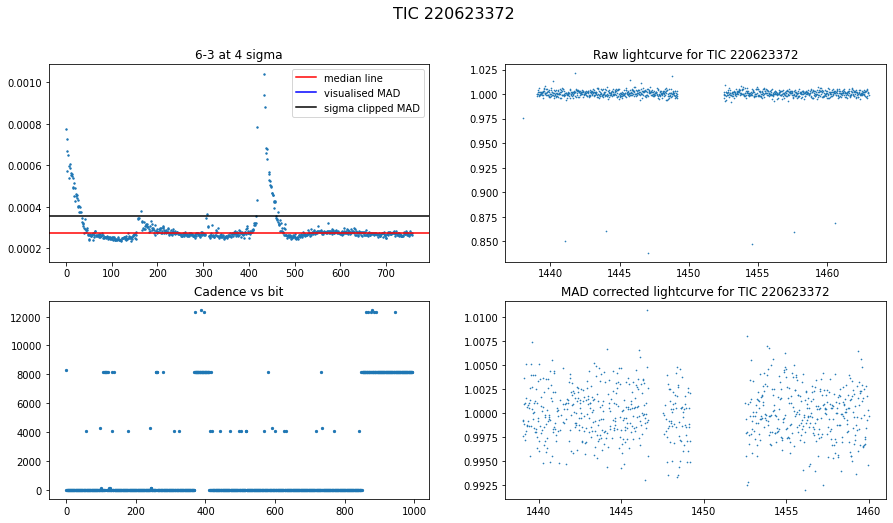

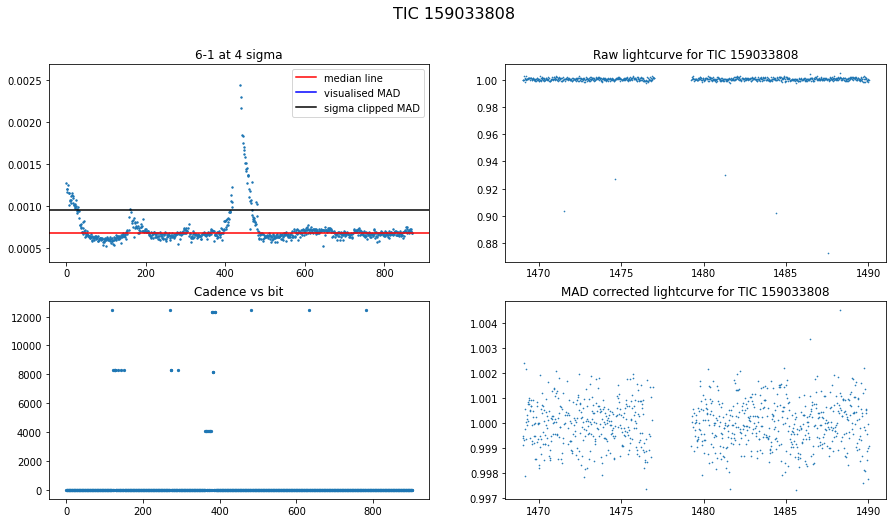

In [8]:
get_lightcurves(data.head(10),path,sec=sec,mad_df=mad_df,plots=True)

### Interpretations:

- MAD excludes data as expected.
- However, some expected points still don't get captured in the processing. After tightening sigma clipping, still the case. Maybe these are just anomalous points that we can do nothing about?

In [10]:
import os

In [11]:
os.listdir(path)

['tesslcs_sector_4_104',
 'tesslcs_sector_5_104',
 'tesslcs_sector_6_104',
 'tesslcs_sector_7_104',
 'tess_s6_tasoc']

In [12]:
for i in data.file.head(10):
    os.listdir(i)

FileNotFoundError: [Errno 2] No such file or directory: 'tesslc_234556256.pkl'